Column(min_height=800, sizing_mode='stretch_both')
    [0] Markdown(str)
    [1] Row
        [0] Select(name='Campus', options=['All', 'BX', 'DF', 'MT'], value='All')
        [1] Select(name='Part Term', options=['All', 'A', 'B', ...], value='All')
    [2] Row
        [0] Select(name='School', options=['All', 'College of Arts a...], value='All')
    [3] Row
        [0] CheckBoxGroup(inline=True, name='Instructional Method', options=['TD', 'BLD'], value=['TD', 'BLD'])
    [4] Row
        [0] CheckBoxGroup(inline=True, name='Course Level', options=['U', 'G'], value=['U', 'G'])
    [5] Row
        [0] Select(name='Value Type', options=['MAXENROLL', ...], value='MAXENROLL')
    [6] ParamFunction(function, _pane=Matplotlib, defer_load=False)
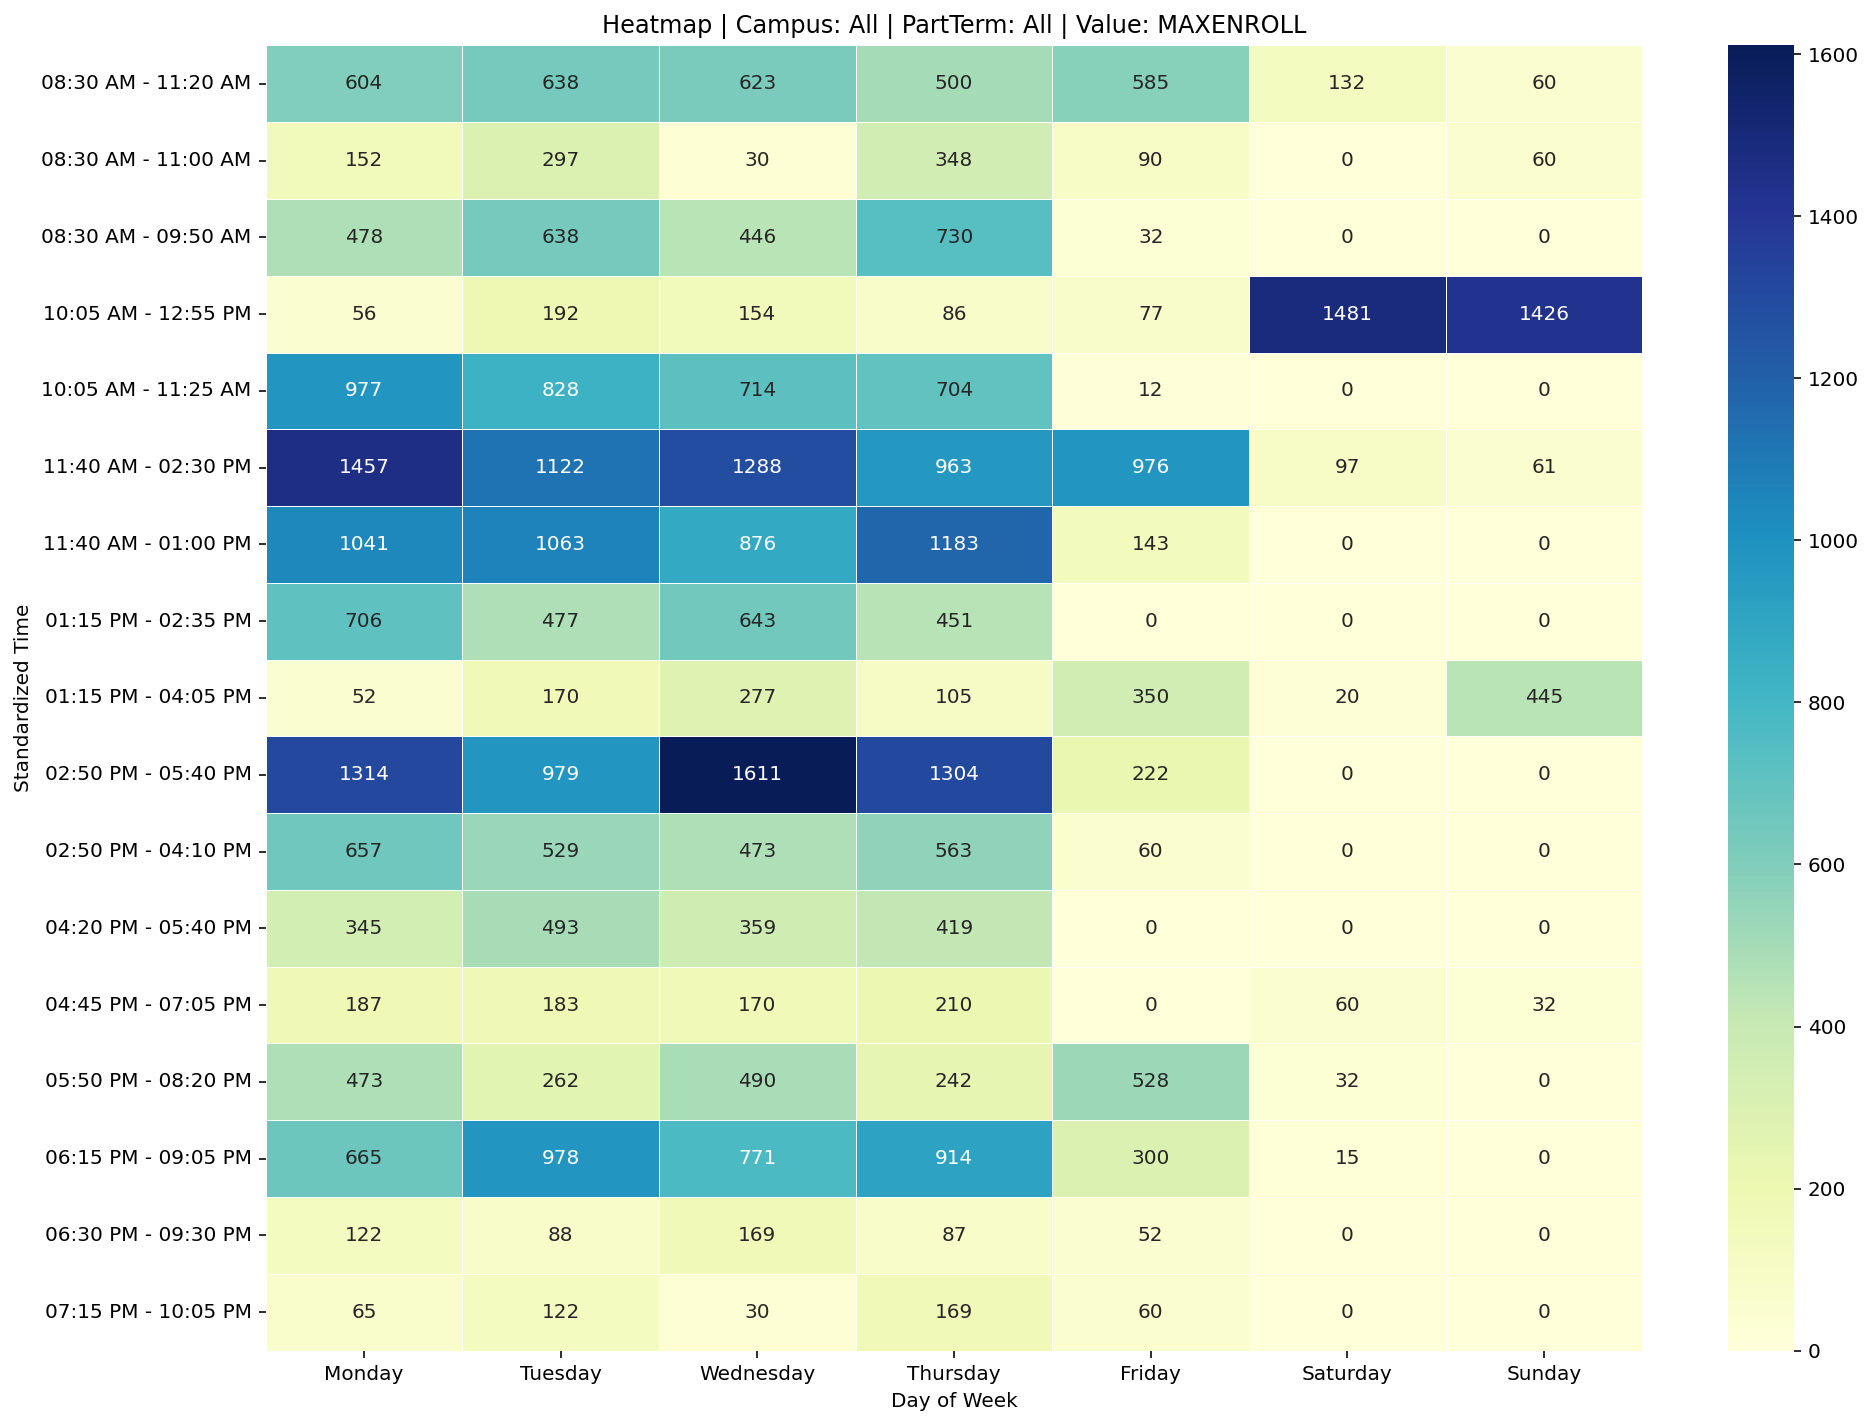

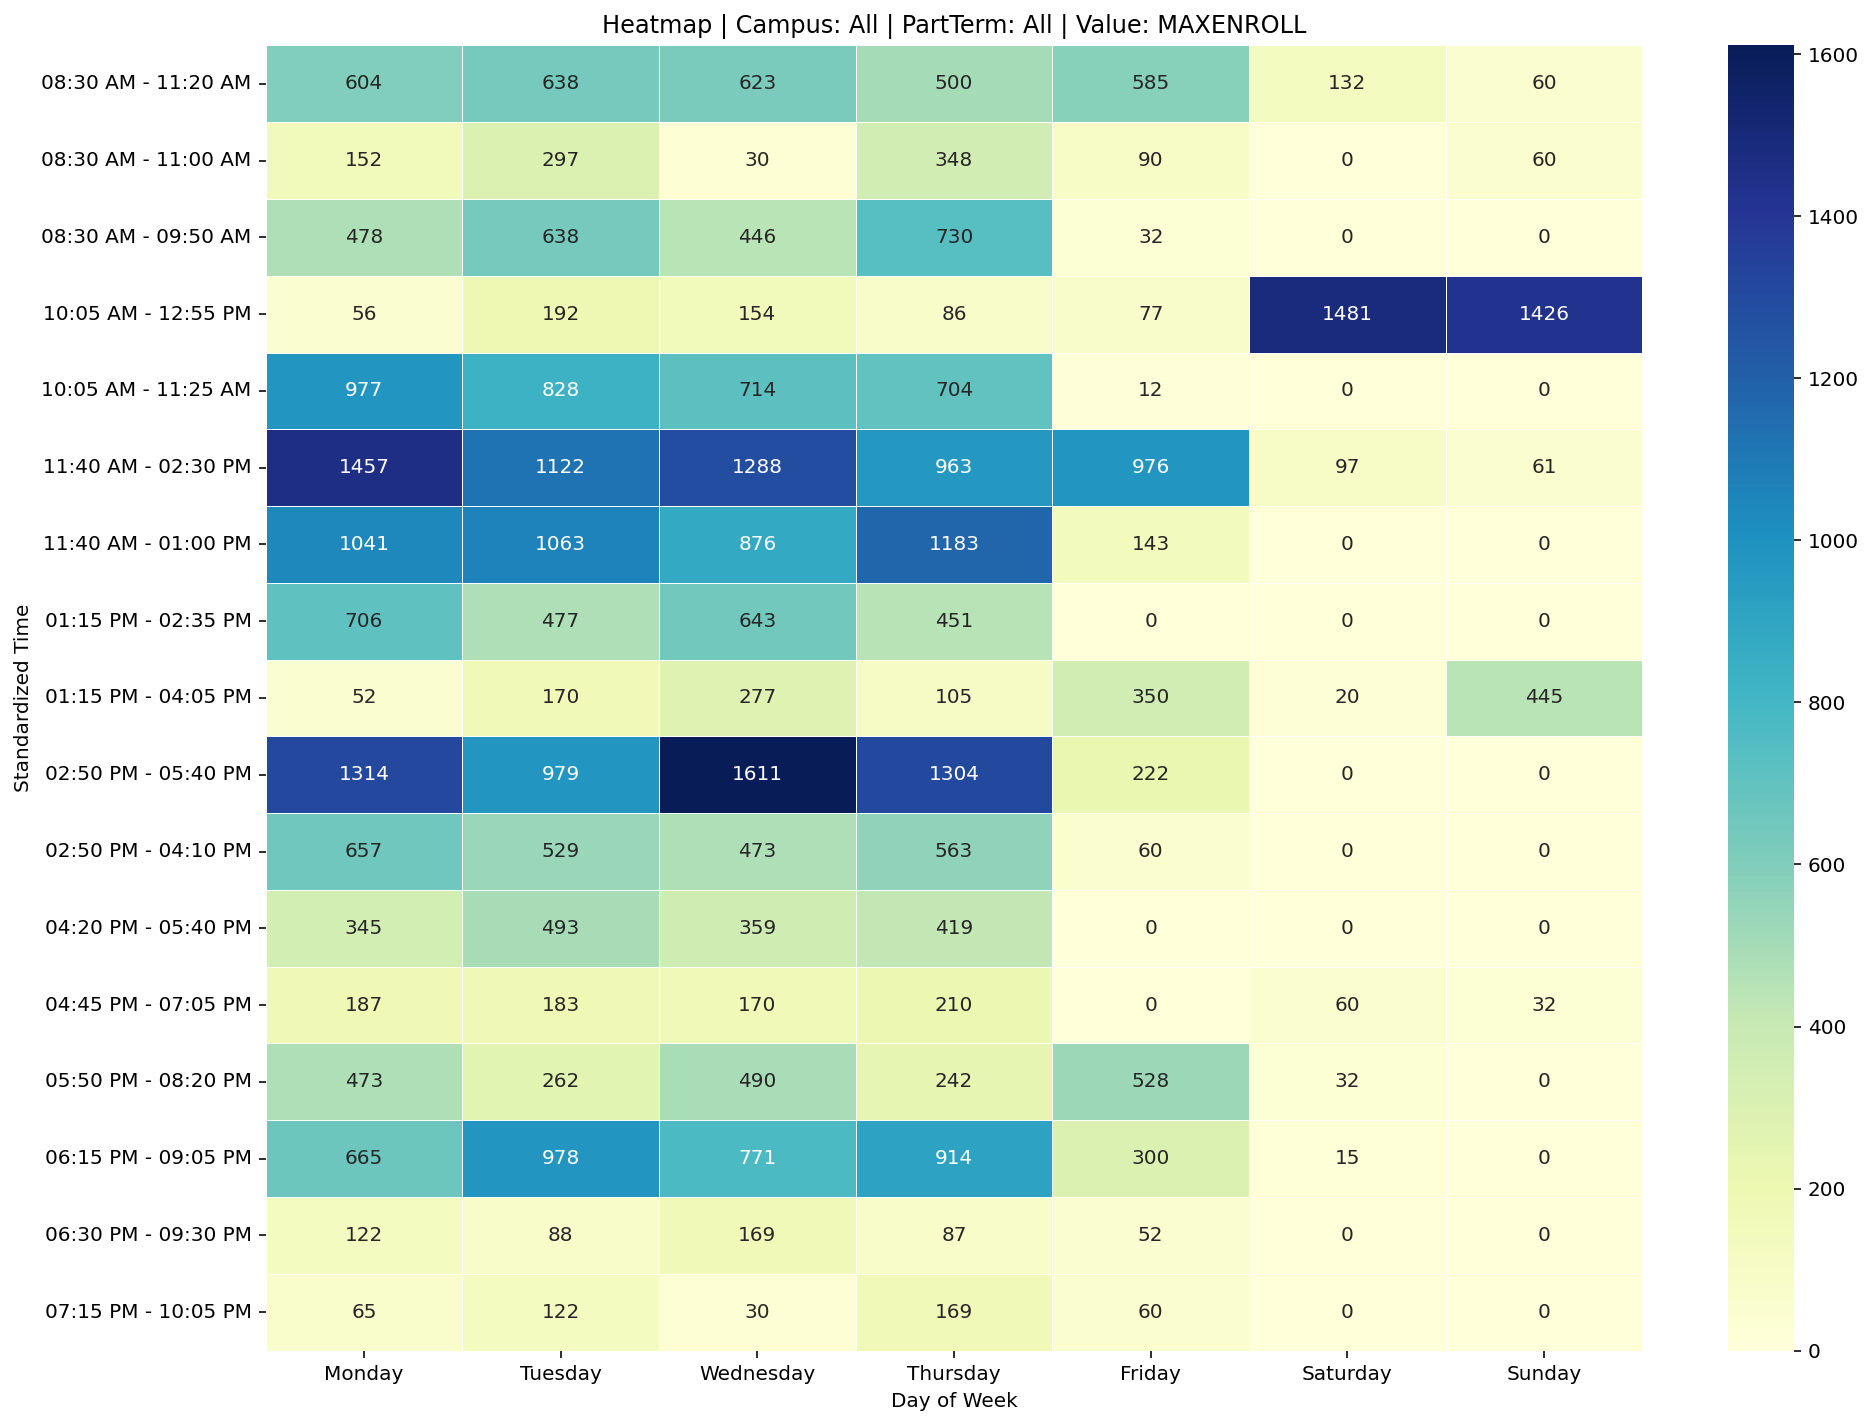

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import panel as pn
pn.extension()

# Load and clean data
df = pd.read_csv('Fall_2025_schedule_standardized.csv')

# Filter for Active courses with TD or BLD methods and required campus
df = df[
    (df['CRSSTATUS'] == 'Active') &
    (df['Inst_Method'].isin(['TD', 'BLD'])) &
    (df['MTGDAYS'].notna()) &
    (df['Standardized_Time'].notna()) &
    (~df['MTGDAYS'].str.upper().eq('TBA')) &
    (~df['Standardized_Time'].str.upper().eq('TBA')) &
    (df['CAMPUS'].isin(['BX', 'DF', 'MT']))
]

# Widgets
campus_select = pn.widgets.Select(name='Campus', options=['All'] + ['BX', 'DF', 'MT'], value='All')
partterm_select = pn.widgets.Select(name='Part Term', options=['All'] + sorted(df['PARTTERM'].dropna().unique()), value='All')

school_options = ['All'] + sorted(df['SCHOOL'].dropna().unique())
school_select = pn.widgets.Select(name='School', options=school_options, value='All')

inst_method_check = pn.widgets.CheckBoxGroup(name='Instructional Method', value=['TD', 'BLD'], options=['TD', 'BLD'], inline=True)
crslevel_check = pn.widgets.CheckBoxGroup(name='Course Level', value=['U', 'G'], options=['U', 'G'], inline=True)

# Add new widget to choose value type
value_column_select = pn.widgets.Select(
    name='Value Type',
    options=['MAXENROLL', 'SECTENROLL'],
    value='MAXENROLL'
)
# Update plotting function to use selected value column
def plot_heatmap(campus, partterm, school, inst_method, crslevel, value_column):
    filtered_df = df.copy()

    if campus != 'All':
        filtered_df = filtered_df[filtered_df['CAMPUS'] == campus]
    if partterm != 'All':
        filtered_df = filtered_df[filtered_df['PARTTERM'] == partterm]
    if school != 'All':
        filtered_df = filtered_df[filtered_df['SCHOOL'] == school]
    if inst_method:
        filtered_df = filtered_df[filtered_df['Inst_Method'].isin(inst_method)]
    if crslevel:
        filtered_df = filtered_df[filtered_df['CRSLEVEL'].isin(crslevel)]

    # Expand days
    days_map = {'M': 'Monday', 'T': 'Tuesday', 'W': 'Wednesday',
                'R': 'Thursday', 'F': 'Friday', 'S': 'Saturday', 'U': 'Sunday'}
    expanded_rows = []
    for _, row in filtered_df.iterrows():
        for d in row['MTGDAYS']:
            if d in days_map:
                expanded_rows.append({
                    'Day': days_map[d],
                    'Standardized_Time': row['Standardized_Time'],
                    value_column: row[value_column]
                })

    heatmap_df = pd.DataFrame(expanded_rows)
    if heatmap_df.empty:
        return pn.pane.Markdown("**No data to display.**")

    # Create pivot table
    pivot_table = heatmap_df.groupby(['Standardized_Time', 'Day'])[value_column].sum().unstack(fill_value=0)

    # Ensure days are ordered
    ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    pivot_table = pivot_table.reindex(columns=ordered_days, fill_value=0)

    # Sort by start time
    def time_sort_key(time_range):
        try:
            start_time = time_range.split(' - ')[0]
            return datetime.strptime(start_time.strip(), '%I:%M %p')
        except:
            return datetime.strptime('12:00 AM', '%I:%M %p')

    pivot_table = pivot_table.sort_index(key=lambda x: x.map(time_sort_key))

    # Plot
    fig, ax = plt.subplots(figsize=(14, 10))
    sns.heatmap(pivot_table, cmap="YlGnBu", linewidths=.5, annot=True, fmt=".0f", ax=ax)
    ax.set_title(f"Heatmap | Campus: {campus} | PartTerm: {partterm} | Value: {value_column}")
    ax.set_xlabel('Day of Week')
    ax.set_ylabel('Standardized Time')
    plt.tight_layout()

    return pn.pane.Matplotlib(fig, tight=True)

# Bind with the new value_column widget
interactive_panel = pn.bind(
    plot_heatmap,
    campus=campus_select,
    partterm=partterm_select,
    school=school_select,
    inst_method=inst_method_check,
    crslevel=crslevel_check,
    value_column=value_column_select
)

# Update layout to include new dropdown
dashboard = pn.Column(
    "# 📊 Fall 2025 Schedule Heatmap (TD/BLD Courses Only)",
    pn.Row(campus_select, partterm_select),
    pn.Row(school_select),
    pn.Row(inst_method_check),
    pn.Row(crslevel_check),
    pn.Row(value_column_select),
    interactive_panel,
    sizing_mode='stretch_width', 
    height=800
)

dashboard.servable()
